In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import glob
import warnings

warnings.filterwarnings('ignore')

sns.set(rc={"figure.dpi":1200})
sns.set_context('notebook')
sns.set_style("ticks")

mpl.style.use('default')

# Update rcParams for global consistency
mpl.rcParams.update({
    'axes.linewidth': 7,           # Line width for axes
    'xtick.major.size': 20,        # Major tick size
    'xtick.major.width': 7,        # Major tick width
    'xtick.minor.size': 10,        # Minor tick size
    'xtick.minor.width': 7,        # Minor tick width
    'ytick.major.size': 20,        # Major tick size
    'ytick.major.width': 7,        # Major tick width
    'ytick.minor.size': 10,        # Minor tick size
    'ytick.minor.width': 7,        # Minor tick width
    'ytick.labelsize': 60,         # Label size for y ticks
    'xtick.labelsize': 60,         # Label size for x ticks
    'font.size': 60,               # Font size for text
    'font.sans-serif': 'Arial',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Arial',
    'mathtext.it': 'Arial',
    'mathtext.bf': 'Arial:bold',
    'lines.linewidth': 7,          # Line width for all lines
    'scatter.marker': 'o',         # Default marker for scatter
    'lines.markersize': 10,        # Marker size for scatter in points
    'axes.titlesize': 'large',     # Title size
    'axes.labelsize': 'large',     # Label size for axes
    'legend.fontsize': 'large'     # Font size for legends
})


In [9]:
###IMPORT DATAFRAMES AND FILTER MAIN LIVE-CELL DATAFRAME
df = pd.read_csv('STALLER_MANUSCRIPT_HIF1A_CITED2_MASTER.csv',index_col=0)
df = df[(df['area']<10000)]
df = df[(df['log directA']>3.1)]
df = df[(df['log directA']<3.9)]
###KEEP ONLY CONSTRUCTS WITH more than 30 cells per well 
# Group by 'ID' and get 'well' value counts for each group
grouped_well_counts = df.groupby('ID')['well'].value_counts()

# Convert the Series to a DataFrame for easier filtering
grouped_well_counts = grouped_well_counts.reset_index(name='count')

# Identify 'ID' and 'well' pairs with a count of 30 or more
valid_wells = grouped_well_counts[grouped_well_counts['count'] >= 30]

# Merge the valid_wells DataFrame back with the original df to filter it
# Only keep rows from df that have 'ID' and 'well' combinations appearing in valid_wells
df_filtered = df.merge(valid_wells[['ID', 'well']], on=['ID', 'well'])

# The df_filtered now contains only the rows from the original df where the 'well' count per 'ID' is 30 or more
df=df_filtered
sim=pd.read_csv('sim.csv',index_col=0)
#select for HIF and CITED2
HIF = df[df['protein'] != 'CITED2']
CITED2 = df[df['protein'] != 'HIF1A']


In [10]:
activity=pd.read_csv('Shahar_ADvariants_20211203.csv')
###SUBTRACT THE BASELINE
activity['Activity_Mean_MSS18'] = activity['Activity_Mean_MSS18'] - 2000
###GET RID OF NEGATIVE VALUES SINCE THEY CAN'T BE BELOW BASELINE
activity.loc[activity['Activity_Mean_MSS18'] < 0, 'Activity_Mean_MSS18'] = 0

activity = activity.drop(columns=['norm_error','start','end'])
mapping = {
    1: 'NQ>W', 2: 'MA>W', 3: 'WT', 4: 'RK>E', 5: 'RK>D', 24: 'GS24',
    6: 'ED>A0to20', 7: 'FML>A', 8: 'L>F', 9: 'L>W', 10: 'WT', 11: 'RK>E',
    12: 'RK>Amut20to39'
}

# Map the 'ID' column to the new 'mut name' column
activity['mut name'] = activity['ID'].map(mapping)
# Create a mask for the condition
condition = activity['ID'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Filter the DataFrame based on the condition
activity = activity[condition]

# Assign 'protein' based on 'ID'
activity['protein'] = activity['ID'].apply(lambda x: 'HIF1a' if x in [1, 2, 3, 4, 5] else 'CITED2')
activity

,ID,Gene,ADseq,Activity_Mean_MSS18,Activity_std_MSS18,MutName,mut name,protein
0,1,Hif1-AD2_46,RLLGWSMDESGLPWLTSYDCEVWAPIWGSRWLLWGEELLRALDWVW,103.122677,576.329705,NQ>W,NQ>W,HIF1a
1,2,Hif1-AD2_46,RLLGQSWDESGLPQLTSYDCEVNWPIQGSRNLLQGEELLRWLDQVN,111.794463,189.483389,MA>W,MA>W,HIF1a
2,3,Hif1-AD2_46,RLLGQSMDESGLPQLTSYDCEVNAPIQGSRNLLQGEELLRALDQVN,695.866145,258.490579,WT,WT,HIF1a
3,4,Hif1-AD2_46,ELLGQSMDESGLPQLTSYDCEVNAPIQGSEFLLQGEELLDALDQVN,2746.673271,996.520233,supercharge6,RK>E,HIF1a
4,5,Hif1-AD2_46,DLLGQSMDESGLPQLTSYDCEVNAPIQGSDNLLQGEELLDALDQVN,2858.260837,808.684618,RK>D,RK>D,HIF1a
5,6,CITED2,TAFIAAAVLMSLVIAMGLARIKELPELWLGQNEFDFMTD,0.000000,452.625360,ED>Amut0to20,ED>A0to20,CITED2
6,7,CITED2,TDAIDEEVAMSAVIEMGLDRIKELPELWLGQNEFDFMTD,0.000000,510.069751,killmotif1,FML>A,CITED2
7,8,CITED2,TDFIDEEVFMSFVIEMGFDRIKEFPEFWFGQNEFDFMTD,81.676282,263.574796,L>F,L>F,CITED2
8,9,CITED2,TDFIDEEVWMSWVIEMGWDRIKEWPEWWWGQNEFDFMTD,317.262431,300.576006,L>W,L>W,CITED2
9,10,CITED2,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTD,2633.448213,835.652083,WT,WT,CITED2


In [11]:
pwd

'/Users/eflores500/Documents/STALLER_MANUSCRIPT/GITHUB/Ef_vs_activity'

In [12]:
# activity = activity[activity['ID'].isin([1, 2, 3, 4, 5])]

# activity['mut name'] = activity['mut name'].replace('supercharge6', 'RK>E')

# wt_value = activity.loc[activity['mut name'] == 'WT', 'Activity_Mean_MSS18'].iloc[0]

# # Create a new column 'normalized activity' by dividing 'Activity_Mean_MSS18' by the WT value
# activity['normalized activity'] = activity['Activity_Mean_MSS18'] / wt_value
# # Find the standard deviation value for the 'WT' mut name
# wt_std = activity[activity['mut name'] == 'WT']['Activity_std_MSS18'].iloc[0]

# # Calculate the normalized error
# activity['normalized error'] = ((activity['Activity_std_MSS18'] / activity['Activity_Mean_MSS18'])**2 + 
#                                 (wt_std / wt_value)**2)**0.5 * activity['normalized activity']

# activity

In [13]:
###normalize activity based on WT and protein
for protein in activity['protein'].unique():
    # Find the WT value and standard deviation for the current protein
    wt_mean = activity.loc[(activity['mut name'] == 'WT') & (activity['protein'] == protein), 'Activity_Mean_MSS18'].iloc[0]
    wt_std = activity.loc[(activity['mut name'] == 'WT') & (activity['protein'] == protein), 'Activity_std_MSS18'].iloc[0]
    
    # Normalize 'Activity_Mean_MSS18' by the WT value for the current protein
    activity.loc[activity['protein'] == protein, 'normalized activity'] = activity['Activity_Mean_MSS18'] / wt_mean
    
    # Calculate the normalized error for the current protein
    activity.loc[activity['protein'] == protein, 'normalized error'] = (
        (activity['Activity_std_MSS18'] / activity['Activity_Mean_MSS18'])**2 + 
        (wt_std / wt_mean)**2
    )**0.5 * activity.loc[activity['protein'] == protein, 'normalized activity']

# Display the updated DataFrame
activity


,ID,Gene,ADseq,Activity_Mean_MSS18,Activity_std_MSS18,MutName,mut name,protein,normalized activity,normalized error
0,1,Hif1-AD2_46,RLLGWSMDESGLPWLTSYDCEVWAPIWGSRWLLWGEELLRALDWVW,103.122677,576.329705,NQ>W,NQ>W,HIF1a,0.148193,0.830047
1,2,Hif1-AD2_46,RLLGQSWDESGLPQLTSYDCEVNWPIQGSRNLLQGEELLRWLDQVN,111.794463,189.483389,MA>W,MA>W,HIF1a,0.160655,0.278762
2,3,Hif1-AD2_46,RLLGQSMDESGLPQLTSYDCEVNAPIQGSRNLLQGEELLRALDQVN,695.866145,258.490579,WT,WT,HIF1a,1.000000,0.525332
3,4,Hif1-AD2_46,ELLGQSMDESGLPQLTSYDCEVNAPIQGSEFLLQGEELLDALDQVN,2746.673271,996.520233,supercharge6,RK>E,HIF1a,3.947129,2.049537
4,5,Hif1-AD2_46,DLLGQSMDESGLPQLTSYDCEVNAPIQGSDNLLQGEELLDALDQVN,2858.260837,808.684618,RK>D,RK>D,HIF1a,4.107487,1.917962
5,6,CITED2,TAFIAAAVLMSLVIAMGLARIKELPELWLGQNEFDFMTD,0.000000,452.625360,ED>Amut0to20,ED>A0to20,CITED2,0.000000,NaN
6,7,CITED2,TDAIDEEVAMSAVIEMGLDRIKELPELWLGQNEFDFMTD,0.000000,510.069751,killmotif1,FML>A,CITED2,0.000000,NaN
7,8,CITED2,TDFIDEEVFMSFVIEMGFDRIKEFPEFWFGQNEFDFMTD,81.676282,263.574796,L>F,L>F,CITED2,0.031015,0.100570
8,9,CITED2,TDFIDEEVWMSWVIEMGWDRIKEWPEWWWGQNEFDFMTD,317.262431,300.576006,L>W,L>W,CITED2,0.120474,0.120370
9,10,CITED2,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTD,2633.448213,835.652083,WT,WT,CITED2,1.000000,0.448762


In [14]:
# Optional: If 'ID' is not suitable for grouping because it's unique to each row, skip this step.
# If you still need to keep 'ID' for reference, consider creating a summary or mapping table separately.

# Step 1: Group by 'protein', 'well', and 'mut name', then calculate the median for each group
medians_by_well_protein = df.groupby(['protein', 'well', 'mut name'])['Ef'].median().reset_index(name='median_Ef')

# Prepare a DataFrame with unique 'ID', 'protein', and 'mut name' for merging later
id_protein_mapping = df[['ID', 'protein', 'mut name']].drop_duplicates()

# Step 2: Calculate the average and standard deviation of these medians for each 'mut name' within each 'protein'
stats_by_protein = medians_by_well_protein.groupby(['protein', 'mut name'])['median_Ef'].agg(
    avg_median='mean',
    std_dev_median='std'
).reset_index()

# Merge the calculated stats with the ID and protein mapping
final_df = pd.merge(stats_by_protein, id_protein_mapping, on=['protein', 'mut name'], how='left')

print(final_df)


   protein       mut name  avg_median  std_dev_median  ID
0   CITED2      ED>A0to20    0.325904        0.024226   6
1   CITED2          FML>A    0.488308        0.004012   7
2   CITED2            L>F    0.573973        0.004804   8
3   CITED2            L>W    0.602027        0.013619   9
4   CITED2  RK>Amut20to39    0.574252        0.007813  12
5   CITED2           RK>E    0.573410        0.007728  11
6   CITED2             WT    0.593447        0.013677  10
7    HIF1A           MA>W    0.553558        0.010212   2
8    HIF1A           NQ>W    0.534500        0.010224   1
9    HIF1A           RK>D    0.405904        0.006478   5
10   HIF1A           RK>E    0.427764        0.006046   4
11   HIF1A             WT    0.452605        0.005809   3


In [15]:
##normalize the medians
# Initialize columns for normalized values and their errors
final_df['normalized_avg_median'] = np.nan
final_df['normalized_error'] = np.nan

# Normalize and calculate errors for each protein type
for protein in final_df['protein'].unique():
    # Identify the WT values for avg_median and std_dev_median
    wt_row = final_df[(final_df['protein'] == protein) & (final_df['mut name'] == 'WT')]
    wt_avg_median = wt_row['avg_median'].values[0]
    wt_std_dev_median = wt_row['std_dev_median'].values[0]

    # Filter rows for current protein
    protein_rows = final_df['protein'] == protein
    
    # Normalize avg_median by the WT value
    final_df.loc[protein_rows, 'normalized_avg_median'] = final_df[protein_rows]['avg_median'] / wt_avg_median
    
    # Propagate error: since std_dev_median is from an average, use relative errors for propagation
    # The formula for error propagation when dividing is sqrt((error_A/A)^2 + (error_B/B)^2) * (A/B)
    final_df.loc[protein_rows, 'normalized_error'] = np.sqrt(
        (final_df[protein_rows]['std_dev_median'] / final_df[protein_rows]['avg_median']) ** 2 +
        (wt_std_dev_median / wt_avg_median) ** 2
    ) * final_df[protein_rows]['normalized_avg_median']

# Display the updated DataFrame
final_df


,protein,mut name,avg_median,std_dev_median,ID,normalized_avg_median,normalized_error
0,CITED2,ED>A0to20,0.325904,0.024226,6,0.549171,0.042739
1,CITED2,FML>A,0.488308,0.004012,7,0.822833,0.020133
2,CITED2,L>F,0.573973,0.004804,8,0.967185,0.023715
3,CITED2,L>W,0.602027,0.013619,9,1.014457,0.032761
4,CITED2,RK>Amut20to39,0.574252,0.007813,12,0.967655,0.025898
5,CITED2,RK>E,0.573410,0.007728,11,0.966235,0.025797
6,CITED2,WT,0.593447,0.013677,10,1.000000,0.032594
7,HIF1A,MA>W,0.553558,0.010212,2,1.223049,0.027485
8,HIF1A,NQ>W,0.534500,0.010224,1,1.180942,0.027204
9,HIF1A,RK>D,0.405904,0.006478,5,0.896817,0.018367


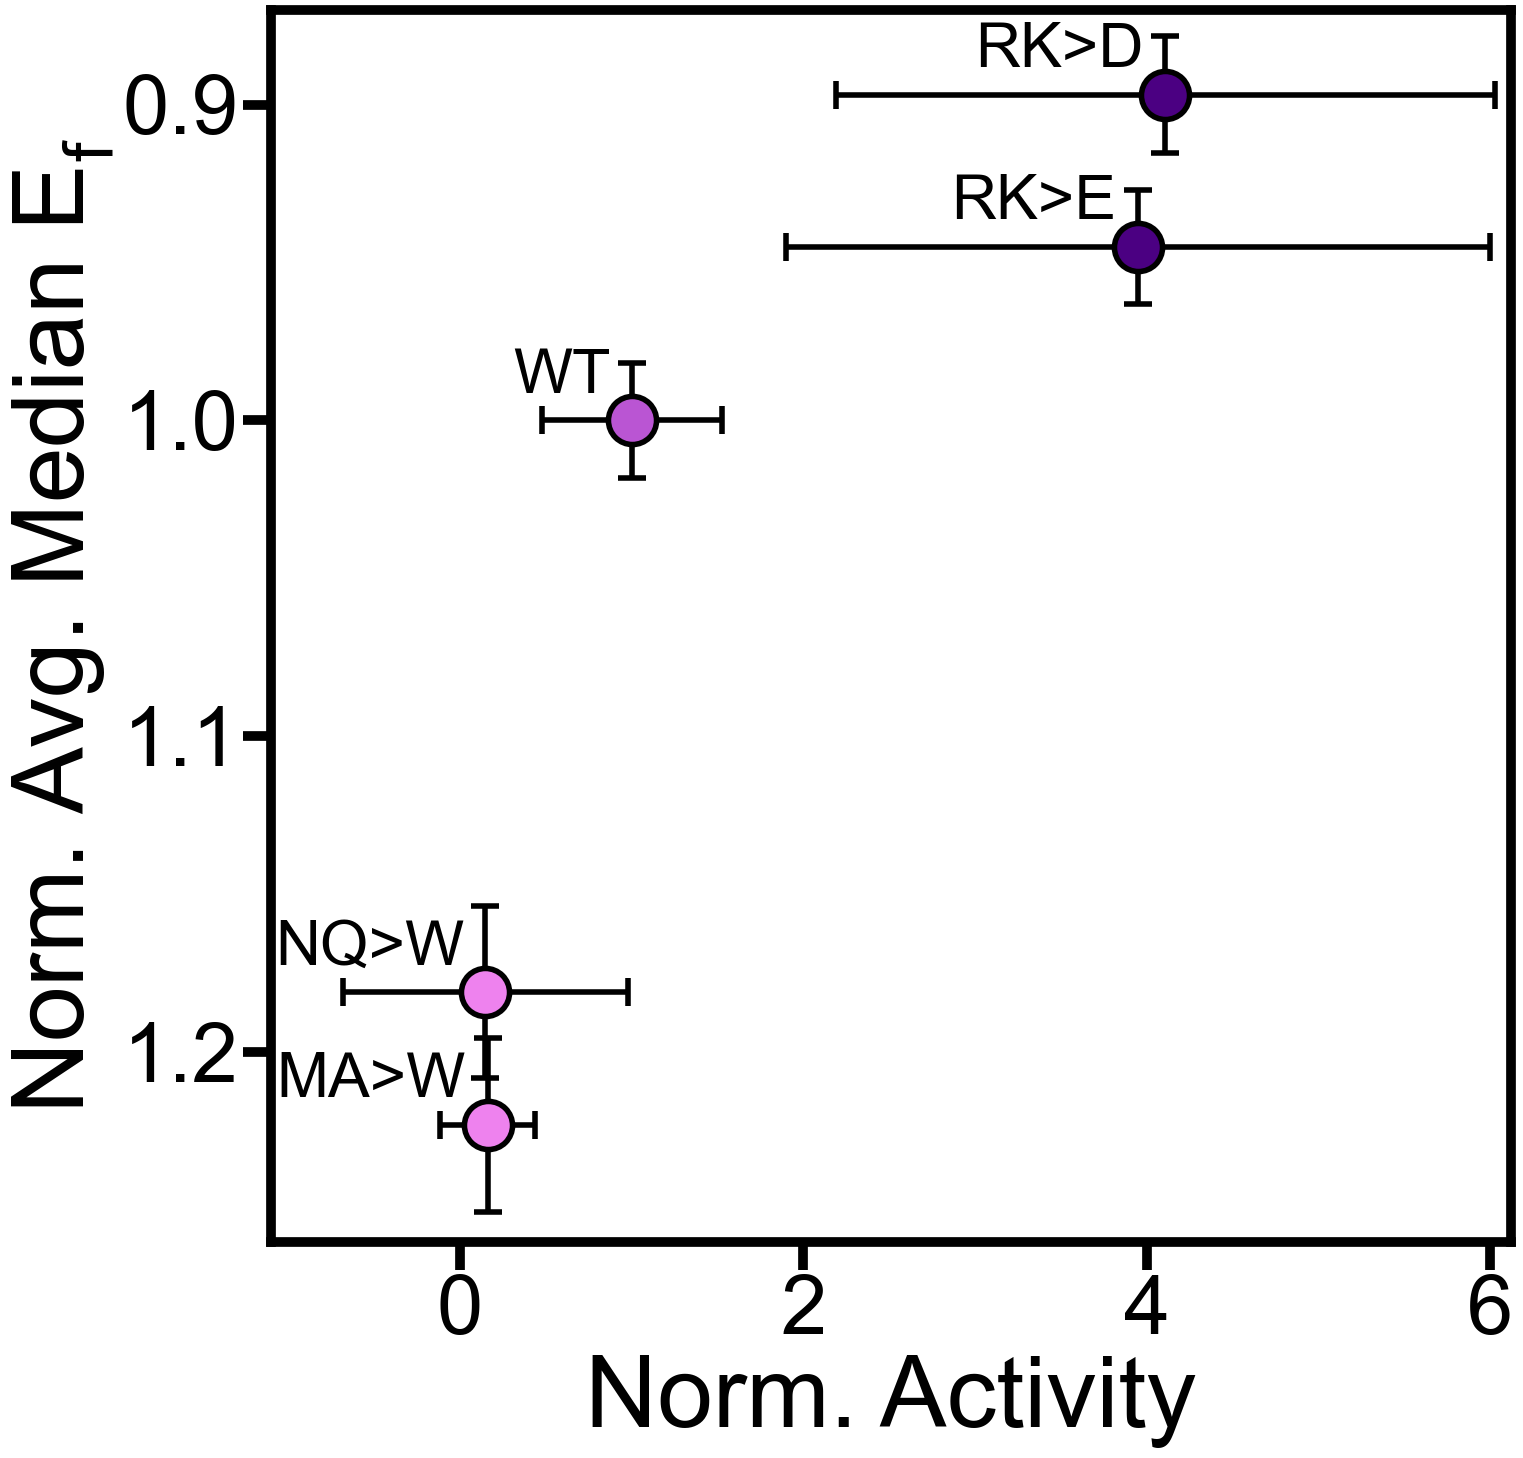

In [20]:

# Correcting protein name consistency in the filter
final_df_HIF1a = final_df[final_df['protein'] == 'HIF1A']
activity_HIF1a = activity[activity['protein'] == 'HIF1a']
# Merge DataFrames on 'mut name' to align normalized activities and medians
merged_df = pd.merge(final_df_HIF1a, activity_HIF1a, on='mut name', suffixes=('_final', '_activity'))

# Color mapping based on mut name
color_mapping = {
    'NQ>W': 'violet',
    'MA>W': 'violet',
    'WT': 'mediumorchid',
    'RK>E': 'indigo',
    'RK>D': 'indigo'
}

# Plotting
plt.figure(figsize=(16, 16))
# Adding error bars for normalized_avg_median and normalized activity
for index, row in merged_df.iterrows():
    # Horizontal error bars (magenta)
    plt.errorbar(row['normalized activity'], row['normalized_avg_median'],
                 xerr=row.get('normalized error', 0),  # Assuming this is your error column for normalized activity
                 fmt='o',  # Use circle markers
                 markersize=25,  # Size of the marker
                 color=color_mapping.get(row['mut name'], 'purple'),  # Use color mapping
                 ecolor='black',  # Color of the horizontal error bars
                 elinewidth=4,  # Width of the error bars
                 capthick=4,
                 capsize=10,  # Length of the caps on the error bars
                 alpha=1)
    # Vertical error bars (purple)
    plt.errorbar(row['normalized activity'], row['normalized_avg_median'],
                 yerr=row['normalized_error'],  # Corrected to use the suffix from merge
                 fmt='none',  # No additional markers
                 ecolor='black',  # Color of the vertical error bars
                 elinewidth=4,  # Width of the error bars
                 capthick=4,
                 capsize=10,  # Length of the caps on the error bars
                 alpha=1)

# Adding text labels for mut name
for index, row in merged_df.iterrows():
    plt.text(row['normalized activity'] - .125,  # X position
             row['normalized_avg_median']-.005,  # Y position
             row['mut name'],
             color='Black',
             fontsize=45,
             ha='right',  # Horizontal alignment
             va='bottom')  # Vertical alignment

# Adding black edge to each scatter point
for index, row in merged_df.iterrows():
    plt.scatter(row['normalized activity'], row['normalized_avg_median'],
                s=1200,  # Size of the marker (25^2)
                color=color_mapping.get(row['mut name'], 'purple'),  # Use color mapping
                edgecolor='black',  # Color of the edge
                zorder=3,
                linewidth=4)  # Width of the edge

plt.xlabel('Norm. Activity')
plt.ylabel('Norm. Avg. Median E$_{f}$')
# Adjust xlim and ylim based on your normalized data range
plt.ylim([1.26, 0.87])  # Adjusted as per your setup
plt.xlim([-1.1, 6.12])  # Adjusted as per your setup
plt.show()

Pearson's r: -0.8963769460262637, p-value: 0.039413974255094054


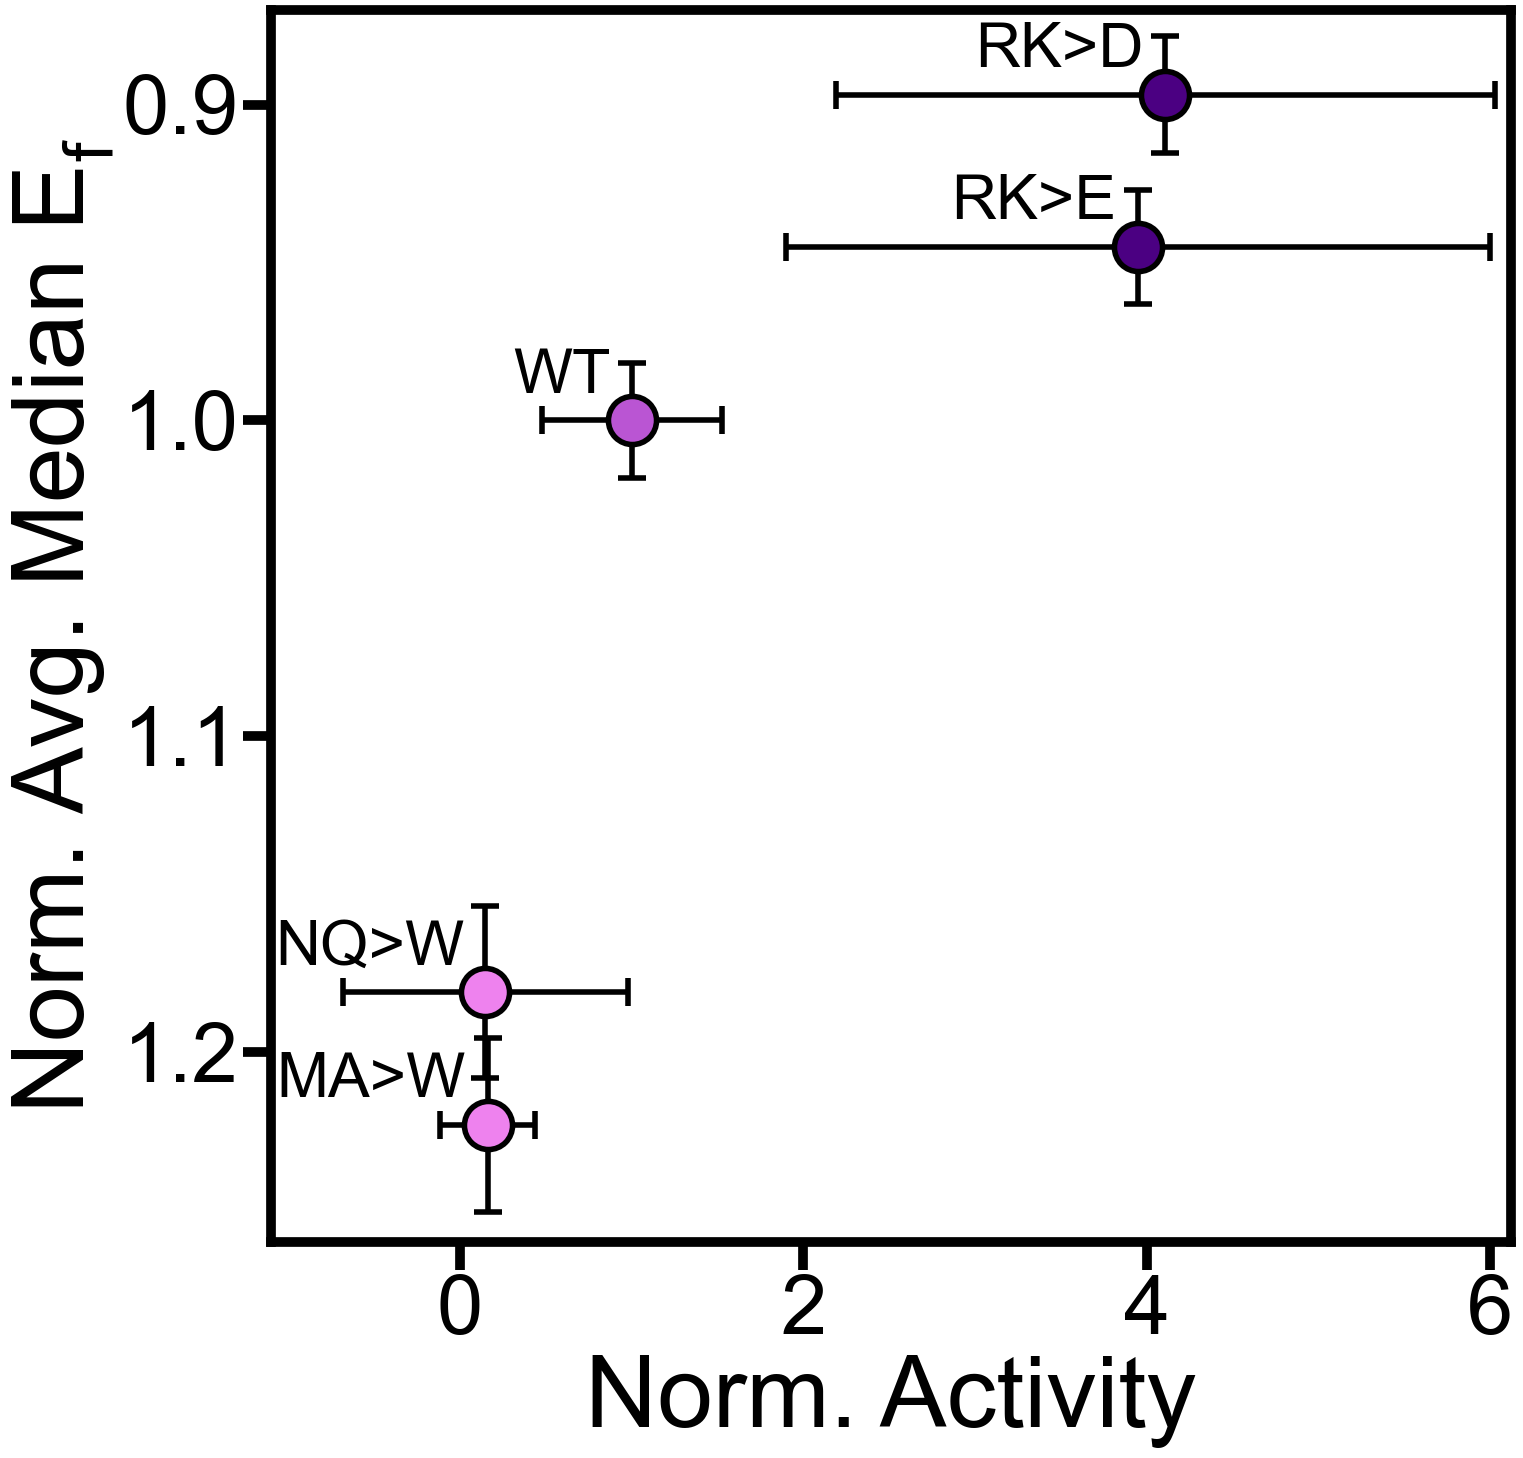

In [17]:
from scipy.stats import pearsonr

# Correcting protein name consistency in the filter
final_df_HIF1a = final_df[final_df['protein'] == 'HIF1A']
activity_HIF1a = activity[activity['protein'] == 'HIF1a']
# Merge DataFrames on 'mut name' to align normalized activities and medians
merged_df = pd.merge(final_df_HIF1a, activity_HIF1a, on='mut name', suffixes=('_final', '_activity'))

# Calculate Pearson's r
pearson_r, p_value = pearsonr(merged_df['normalized activity'], merged_df['normalized_avg_median'])
print(f"Pearson's r: {pearson_r}, p-value: {p_value}")

# Color mapping based on mut name
color_mapping = {
    'NQ>W': 'violet',
    'MA>W': 'violet',
    'WT': 'mediumorchid',
    'RK>E': 'indigo',
    'RK>D': 'indigo'
}

# Plotting
plt.figure(figsize=(16, 16))
# Adding error bars for normalized_avg_median and normalized activity
for index, row in merged_df.iterrows():
    # Horizontal error bars (magenta)
    plt.errorbar(row['normalized activity'], row['normalized_avg_median'],
                 xerr=row.get('normalized error', 0),  # Assuming this is your error column for normalized activity
                 fmt='o',  # Use circle markers
                 markersize=25,  # Size of the marker
                 color=color_mapping.get(row['mut name'], 'purple'),  # Use color mapping
                 ecolor='black',  # Color of the horizontal error bars
                 elinewidth=4,  # Width of the error bars
                 capthick=4,
                 capsize=10,  # Length of the caps on the error bars
                 alpha=1)
    # Vertical error bars (purple)
    plt.errorbar(row['normalized activity'], row['normalized_avg_median'],
                 yerr=row['normalized_error'],  # Corrected to use the suffix from merge
                 fmt='none',  # No additional markers
                 ecolor='black',  # Color of the vertical error bars
                 elinewidth=4,  # Width of the error bars
                 capthick=4,
                 capsize=10,  # Length of the caps on the error bars
                 alpha=1)

# Adding text labels for mut name
for index, row in merged_df.iterrows():
    plt.text(row['normalized activity'] - .125,  # X position
             row['normalized_avg_median']-.005,  # Y position
             row['mut name'],
             color='Black',
             fontsize=45,
             ha='right',  # Horizontal alignment
             va='bottom')  # Vertical alignment

# Adding black edge to each scatter point
for index, row in merged_df.iterrows():
    plt.scatter(row['normalized activity'], row['normalized_avg_median'],
                s=1200,  # Size of the marker (25^2)
                color=color_mapping.get(row['mut name'], 'purple'),  # Use color mapping
                edgecolor='black',  # Color of the edge
                zorder=3,
                linewidth=4)  # Width of the edge

plt.xlabel('Norm. Activity')
plt.ylabel('Norm. Avg. Median E$_{f}$')
# Adjust xlim and ylim based on your normalized data range
plt.ylim([1.26, 0.87])  # Adjusted as per your setup
plt.xlim([-1.1, 6.12])  # Adjusted as per your setup

plt.show()


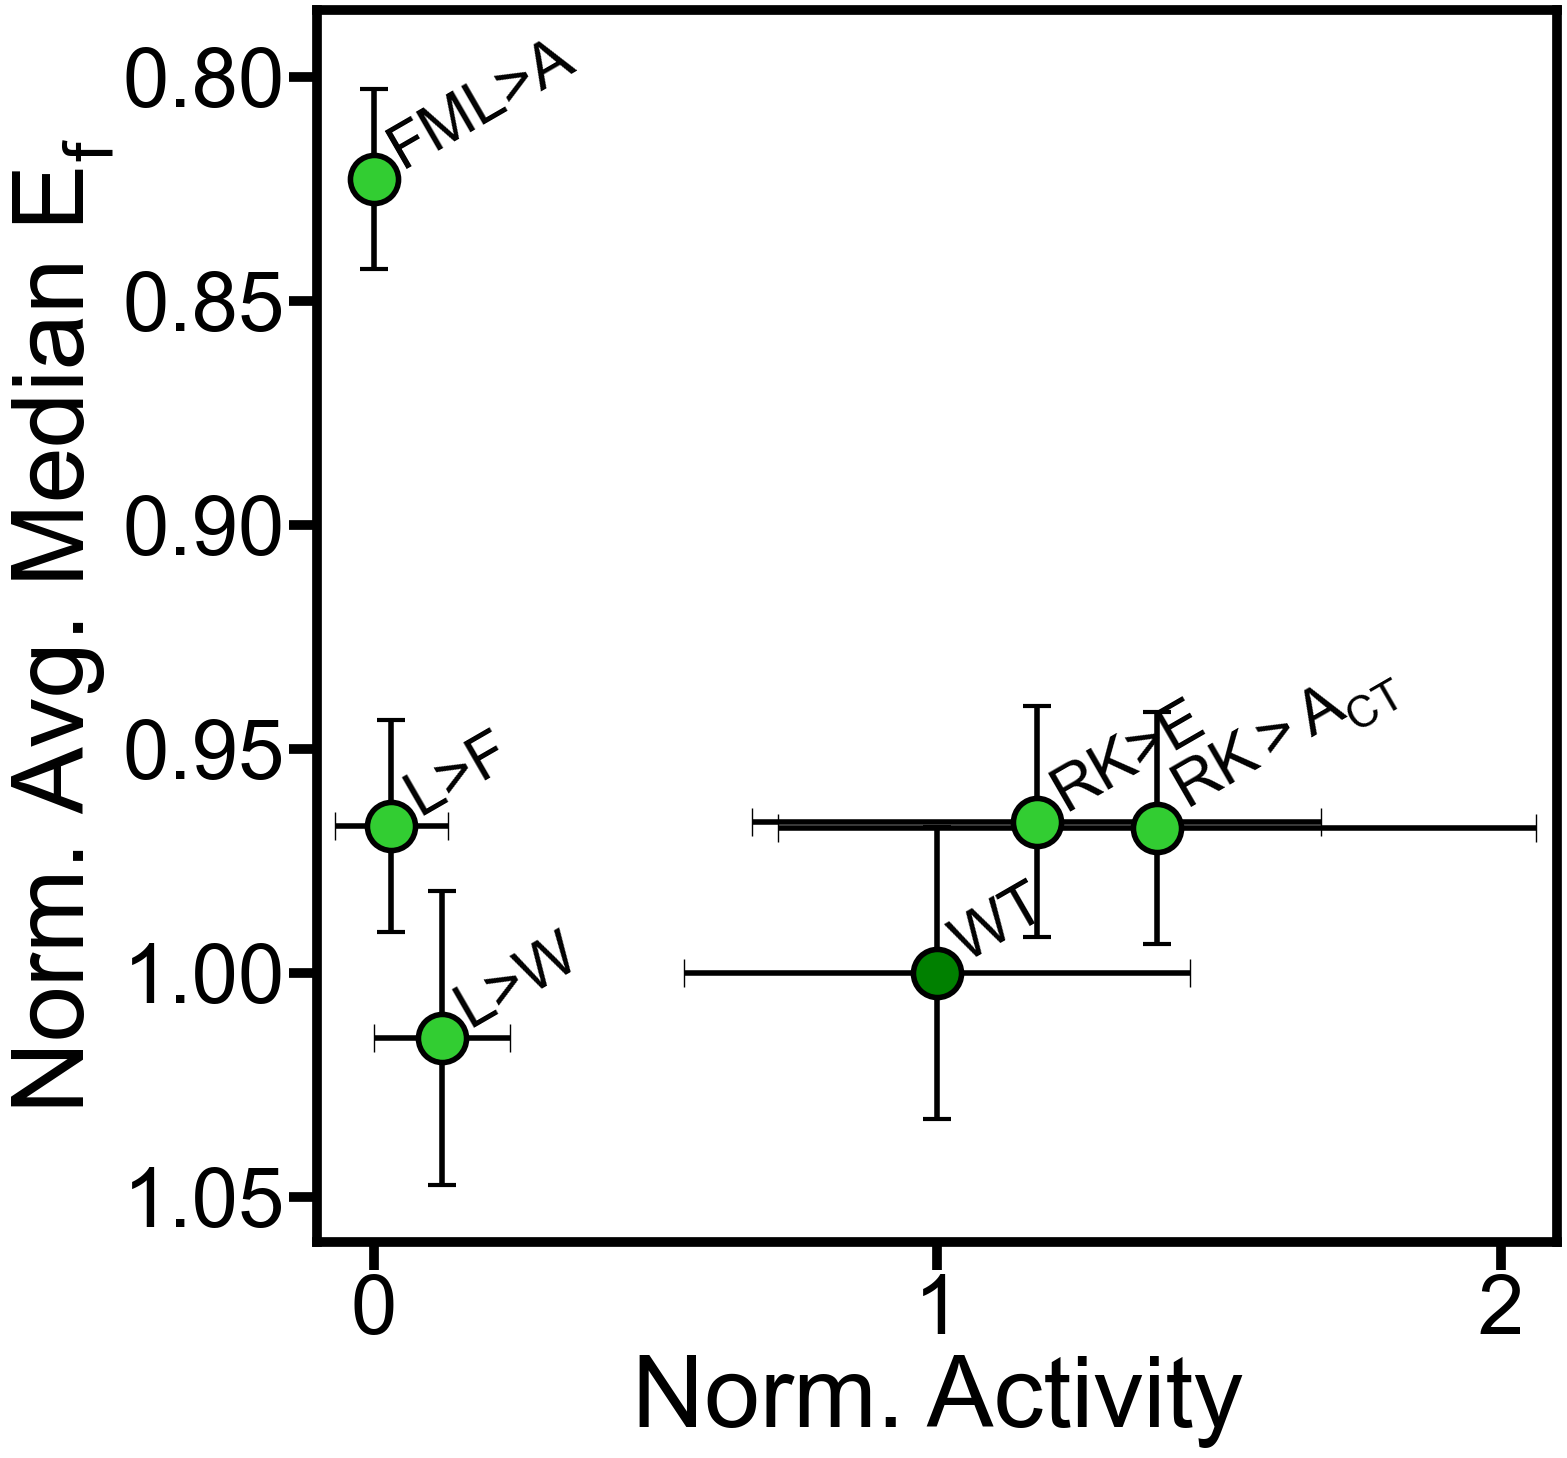

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Specified mutants in the desired order
mut_names = ['FML>A', 'L>F', 'L>W', 'WT', 'RK>E', 'RK>Amut20to39']

# Correcting protein name consistency in the filter
final_df_HIF1a = final_df[final_df['protein'] == 'CITED2']
activity_HIF1a = activity[activity['protein'] == 'CITED2']
# Merge DataFrames on 'mut name' to align normalized activities and medians
merged_df = pd.merge(final_df_HIF1a, activity_HIF1a, on='mut name', suffixes=('_final', '_activity'))

# Filter the merged_df to include only the specified mutants
merged_df = merged_df[merged_df['mut name'].isin(mut_names)]

# Reorder the DataFrame based on the specified mutant names
merged_df['mut name'] = pd.Categorical(merged_df['mut name'], categories=mut_names, ordered=True)
merged_df = merged_df.sort_values('mut name')

# Color mapping based on mut name
color_mapping = {
    'FML>A': 'LimeGreen',
    'L>F': 'LimeGreen',
    'L>W': 'LimeGreen',
    'WT': 'green',
    'RK>E': 'LimeGreen',
    'RK>Amut20to39': 'LimeGreen'  # Assuming a color for RK>Amut20to39
}

# Plotting
plt.figure(figsize=(16, 16))

# Adding error bars for normalized_avg_median and normalized activity
for index, row in merged_df.iterrows():
    color = color_mapping.get(row['mut name'], 'green')  # Default color if not found in mapping
    # Horizontal error bars 
    plt.errorbar(row['normalized activity'], row['normalized_avg_median'], 
                 xerr=row.get('normalized error', 0),  # Assuming this is your error column for normalized activity
                 fmt='o',  # Use circle markers
                 markersize=25,  # Size of the marker
                 color=color,  # Color of the marker
                 ecolor='black',  # Color of the horizontal error bars
                 elinewidth=4,  # Width of the error bars
                  
                 capsize=10,  # Length of the caps on the error bars
                 alpha=1)
    # Vertical error bars (purple)
    plt.errorbar(row['normalized activity'], row['normalized_avg_median'], 
                 yerr=row['normalized_error'],  # Corrected to use the suffix from merge
                 fmt='none',  # No additional markers
                 ecolor='black',  # Color of the vertical error bars
                 elinewidth=4,  # Width of the error bars
                 capthick=3,
                 capsize=10,  # Length of the caps on the error bars
                 alpha=1)
    
# Adding text labels for mut name
label_replacements = {
    'ED>A0to20': 'ED$>A_{NT}$',
    'RK>Amut20to39': 'RK$>A_{CT}$'
}
for index, row in merged_df.iterrows():
    # Replace the label if it is in the dictionary
    label = label_replacements.get(row['mut name'], row['mut name'])
    plt.text(row['normalized activity'] + 0.01, row['normalized_avg_median'],
             label,
             color='Black',
             fontsize=45,
             rotation=30,
             ha='left',
             va='bottom')
# Adding black edge to each scatter point
for index, row in merged_df.iterrows():
    color = color_mapping.get(row['mut name'], 'green')  # Default color if not found in mapping
    plt.scatter(row['normalized activity'], row['normalized_avg_median'],
                s=1200,  # Size of the marker (25^2)
                color=color,  # Color of the marker
                edgecolor='black',# Color of the edge
                zorder=3,
                linewidth=4)  # Width of the edge
    
plt.xlabel('Norm. Activity')
plt.ylabel('Norm. Avg. Median E$_{f}$')

# Adjust xlim and ylim based on your normalized data range
plt.xlim([-0.1, 2.1])  # Uncomment and adjust as needed
plt.ylim([1.06, 0.785])  # Adjusted as per your setup

plt.show()